<a href="https://colab.research.google.com/github/sofiaElenaHopartean/NLP_recipes/blob/main/recipes_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports

In [1]:
# !pip install tensorflow-addons
# !pip install livelossplot

In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
from functools import partial
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# from keras.utils import to_categorical
import pickle
import time
import pandas as pd
import numpy as np 

import spacy
import pandas as pd
import numpy as np
import csv
# import explacy
from spacy import displacy
from spacy.util import minibatch, compounding
import random
import time

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

import sys
import warnings
import unicodedata
import re

warnings.filterwarnings("ignore")

In [2]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

from tensorflow.keras.models import load_model

### Text Preprocessing

In [3]:
recipes_df = pd.read_csv("drive/MyDrive/recipes/recipes.csv", delimiter=";")
print(recipes_df.shape)
recipes_df.head(3)

(12351, 10)


,Recipe Name,Review Count,Recipe Photo,Author,Prepare Time,Cook Time,Total Time,Ingredients,Directions,RecipeID
0,Golden Crescent Rolls Recipe,304,https://images.media-allrecipes.com/userphotos...,Mike A.,25 m,15 m,3 h 10 m,"yeast,water,white sugar,salt,egg,butter,flour,...","Dissolve yeast in warm water.**Stir in sugar, ...",7000
1,Poppy Seed Bread with Glaze Recipe,137,https://images.media-allrecipes.com/userphotos...,Christina Jun,15 m,1 h,1 h 20 m,"flour,salt,baking powder,poppy,butter,vegetabl...",'Preheat oven to 350 degrees F (175 degrees C)...,7001
2,Applesauce Bread I Recipe,124,https://images.media-allrecipes.com/userphotos...,GAF55,10 m,1 h 20 m,1 h 30 m,"flour,egg,white sugar,vegetable oil,applesauce...",Preheat oven to 350 degrees F (175 degrees C)....,7003


In [4]:
recipes_df_small = recipes_df[~recipes_df['Directions'].isna()][["Directions", "Ingredients"]]
print(recipes_df_small.shape)
recipes_df_small.head(3)

(12345, 2)


,Directions,Ingredients
0,"Dissolve yeast in warm water.**Stir in sugar, ...","yeast,water,white sugar,salt,egg,butter,flour,..."
1,'Preheat oven to 350 degrees F (175 degrees C)...,"flour,salt,baking powder,poppy,butter,vegetabl..."
2,Preheat oven to 350 degrees F (175 degrees C)....,"flour,egg,white sugar,vegetable oil,applesauce..."


In [5]:
directions_lengths = [ len(str) for str in recipes_df_small["Directions"]]
ingredients_lengths = [ len(str) for str in recipes_df_small['Ingredients']]

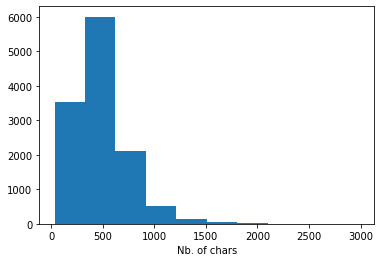

In [6]:
plt.hist(directions_lengths)
plt.xlabel("Nb. of chars")
plt.show()

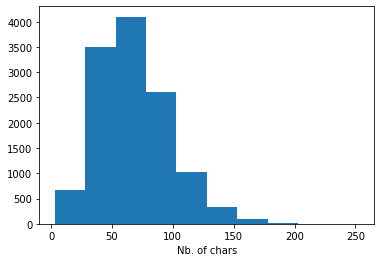

In [7]:
plt.hist(ingredients_lengths)
plt.xlabel("Nb. of chars")
plt.show()

In [8]:
special_chrs = [chr for chr in set(''.join(recipes_df_small["Directions"])) if not chr.isalnum()]
special_chrs.extend([chr for chr in set(''.join(recipes_df_small["Ingredients"])) if not chr.isalnum()])
special_chrs = list(set(special_chrs))
print(special_chrs)

[',', '#', "'", '-', '<', '*', ')', '\x99', '+', '{', '®', '"', '/', '?', ' ', '(', '>', '=', '.', ':', '%', '}', '!', '&']


In [9]:
# for index, row in recipes_df_small.iterrows():
#   print(index)
#   _dirs = unicodedata.normalize('NFKD', row["Directions"]).encode('ascii', 'ignore').decode("utf-8")
#   _ingreds = unicodedata.normalize('NFKD', row["Ingredients"]).encode('ascii', 'ignore').decode("utf-8")
  
#   for sp_chr in special_chrs: 
#     _dirs = _dirs.replace(sp_chr, " ")
#     if sp_chr != ",":
#       _ingreds = _ingreds.replace(sp_chr, " ")
#   print(' '.join(_dirs.split()))
#   print(' '.join(_ingreds.split()))
#   break

# unicodedata.normalize('NFKD', recipes_df_small["Ingredients"][1]).encode('ascii', 'ignore').decode("utf-8").split(",")


def preprocess_dirs(text):
  _dirs = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode("utf-8")
  for sp_chr in special_chrs: 
    _dirs = _dirs.replace(sp_chr, " ")
  _dirs = re.sub('\d', '', _dirs)
  return ' '.join(_dirs.split())

def preprocess_ingred(text):
  _ingreds = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode("utf-8")
  for sp_chr in special_chrs: 
    if sp_chr != ",":
      _ingreds = _ingreds.replace(sp_chr, " ")
  _ingreds = re.sub('\d', '', _ingreds)
  return ' '.join(_ingreds.split())

recipes_df_small["lo_directions"] = recipes_df_small["Directions"].str.lower()
recipes_df_small["lo_ingredients"] = recipes_df_small["Ingredients"].str.lower()

recipes_df_small["norm_directions"] = recipes_df_small["lo_directions"].apply(preprocess_dirs)
recipes_df_small["norm_ingredients"] = recipes_df_small["lo_ingredients"].apply(preprocess_ingred)

recipes_df_small.head(3)

,Directions,Ingredients,lo_directions,lo_ingredients,norm_directions,norm_ingredients
0,"Dissolve yeast in warm water.**Stir in sugar, ...","yeast,water,white sugar,salt,egg,butter,flour,...","dissolve yeast in warm water.**stir in sugar, ...","yeast,water,white sugar,salt,egg,butter,flour,...",dissolve yeast in warm water stir in sugar sal...,"yeast,water,white sugar,salt,egg,butter,flour,..."
1,'Preheat oven to 350 degrees F (175 degrees C)...,"flour,salt,baking powder,poppy,butter,vegetabl...",'preheat oven to 350 degrees f (175 degrees c)...,"flour,salt,baking powder,poppy,butter,vegetabl...",preheat oven to degrees f degrees c grease bot...,"flour,salt,baking powder,poppy,butter,vegetabl..."
2,Preheat oven to 350 degrees F (175 degrees C)....,"flour,egg,white sugar,vegetable oil,applesauce...",preheat oven to 350 degrees f (175 degrees c)....,"flour,egg,white sugar,vegetable oil,applesauce...",preheat oven to degrees f degrees c grease and...,"flour,egg,white sugar,vegetable oil,applesauce..."


In [10]:
words_lo_dirs = set()
words_norm_dirs = set()
sentence_sz_lo_dirs = []
sentence_sz_norm_dirs = []
for _, row in recipes_df_small.iterrows():
  words_lo_dirs.update(row["lo_directions"].split())
  sentence_sz_lo_dirs.append(len(row["lo_directions"].split()))
  words_norm_dirs.update(row['norm_directions'].split())
  sentence_sz_norm_dirs.append(len(row["norm_directions"].split()))
print("lower directions: nb of distinct words :", len(words_lo_dirs),
      "max sentece size:", max(sentence_sz_lo_dirs))
print("nb of distinct words norma:", len(words_norm_dirs),
      "max sentece size:", max(sentence_sz_norm_dirs))


lower directions: nb of distinct words : 20905 max sentece size: 546
nb of distinct words norma: 5366 max sentece size: 524


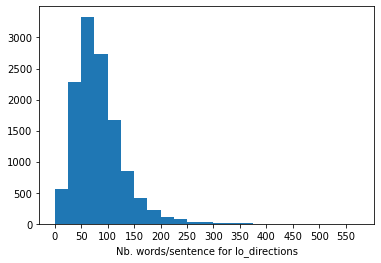

In [11]:
plt.hist(sentence_sz_lo_dirs, bins=np.arange(0, 600, 25))
plt.xticks(range(0, 600, 50))
plt.xlabel("Nb. words/sentence for lo_directions")
plt.show()

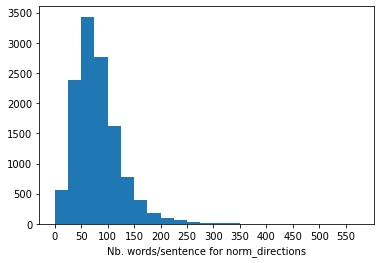

In [12]:
plt.hist(sentence_sz_norm_dirs, bins=np.arange(0, 600, 25))
plt.xticks(range(0, 600, 50))
plt.xlabel("Nb. words/sentence for norm_directions")
plt.show()

### Params

In [13]:
params = {
    'dim' : 300,            # dimension of embeddings
    'maximum_steps' : 1000, # number of training steps        
    'lstm_size' : 150,      # dimension of LSTM
    'batch_size' : 25,      # batch size
    'max_words' : 21000,  #/ 10000,    # maximum number of words to embed
    'padding_size' : 150,    #20 maximum sentence size
    'num_classes' : 5,     # number of unique classes
    'save_dir' : 'drive/MyDrive/recipes/saved_model_tf/model4/' # directory to save hash tables, model weights, etc.
}

colname1, colname2 = 'norm_directions', 'norm_ingredients'

### Helpers & tokenizer

In [14]:
def save_obj(directory, obj, name):
    '''Helper function using pickle to save and load objects'''
    with open(directory + name + '.pkl', 'wb+') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(directory, name):
    '''Helper function using pickle to save and load objects'''
    with open(directory + name + ".pkl", "rb") as f:
        return pickle.load(f)

In [19]:
def make_tokenizer(df, colname1, colname2, params = params):
    ''' In order for one hot encoding of words and labels to work, 
    every word and label has to be seen at least once to make a hashing table.
    This function outputs hash tables for the words and the labels
    that can be used to one-hot-encode them in the generator
    '''
    # Load parameters and data
    max_words = params['max_words']
    save_dir = params['save_dir']
    data_x = []
    for _, line in df.iterrows():
        data_x.append(line[colname1])
            
    # Use the Keras tokenizer API to generate hashing table for data_x
    sp_chr = set(special_chrs)
    sp_chr.update('!"#$%&()*+,./:;<=>?@[\\]^_`{|}~\t\n')
    filter = ''.join(list(sp_chr)).replace("-", "").replace(" ", "")
    tokenizer = Tokenizer(num_words = max_words, filters=filter)
    tokenizer.fit_on_texts(data_x)
    word_index = tokenizer.word_index
    # print(len(word_index))
    # print(word_index)
    word_index["ENDPAD"] = len(word_index)+1 
    word_lookup= [''] * (len(word_index)+1)
    for key, val in word_index.items():
      word_lookup[val]=key
    
    # labels_index = dict([(y, x + 1) for x, y in enumerate(sorted(set(data_y_flattened)))])
    labels_index = {'O':0, 'S-INGREDIENT':1, 'B-INGREDIENT':2, 'I-INGREDIENT':3, 'E-INGREDIENT':4}
    labels_lookup = {0:'O', 1:'S-INGREDIENT', 2:'B-INGREDIENT', 3:'I-INGREDIENT', 4:'E-INGREDIENT'}
    
    for item, name in zip([word_index, labels_index, labels_lookup, word_lookup, tokenizer, sp_chr],
                          ["word_index", "labels_index", "labels_lookup", "word_lookup", "tokenizer", "sp_chr"]):
        save_obj(save_dir, item, name)
    return word_index, word_lookup, labels_index, labels_lookup, tokenizer, sp_chr

In [21]:
word_index, word_lookup, labels_index, labels_lookup, tokenizer, sp_chr = \
  make_tokenizer(recipes_df_small[[colname1, colname2]],
                 colname1, colname2)

In [23]:
print(labels_lookup)
print(labels_index)
print(len(word_index))
print(len(word_lookup))
word_index['ENDPAD']

{0: 'O', 1: 'S-INGREDIENT', 2: 'B-INGREDIENT', 3: 'I-INGREDIENT', 4: 'E-INGREDIENT'}
{'O': 0, 'S-INGREDIENT': 1, 'B-INGREDIENT': 2, 'I-INGREDIENT': 3, 'E-INGREDIENT': 4}
5367
5368


5367

### Data split

In [25]:
X, y = [], []
for index, line in recipes_df_small[[colname1, colname2]].iterrows():
  _descr = line[colname1]
  _ingreds = re.split(',\s*', line[colname2])
  for ingred in _ingreds:
    replc = "S-INGREDIENT"
    parts = ingred.split(" ")
    if len(parts)==1: replc = "S-INGREDIENT"
    elif len(parts)==2: replc = "B-INGREDIENT E-INGREDIENT"
    else: 
      replc = "B-INGREDIENT " +" ".join(["I-INGREDIENT"]*(len(parts)-2)) +" E-INGREDIENT"
    
    if ingred in _descr:
      _descr = _descr.replace(ingred, replc)
    # elif len(parts)>1:
    #   init_len = len(parts)
    #   for sz in range(init_len-1, 0,-1):
    #     for part_ingred in 
  _descr = _descr.split()
  _labels = [ w if w in labels_index.keys() else "O" for w in _descr]
  

  # _labels = [ "INGREDIENT" if word in _ingred else "O" for word in _descr]
  
  words = [word_index.get(x) if x in word_index.keys() else 0 
            for x in line[colname1].split()]
  labels = [labels_index.get(y) for y in _labels]

  X.append(words)
  y.append(labels)

# print(X[1])
# print(y[1])

X = pad_sequences(X, maxlen = params['padding_size'], value = word_index["ENDPAD"], padding = "post")
y = pad_sequences(y, maxlen = params['padding_size'], value = labels_index["O"], padding = "post")
y_cat = [to_categorical(i, num_classes = params['num_classes']) for i in y]

# print(X[1])
# print(y[1])
# print(y_cat[1])

X_train, X_test, y_train, y_test = train_test_split(X,y_cat, train_size=0.9, random_state= 11 )

# X = recipes_df_small[colname1].copy()
# y = recipes_df_small[colname2].copy()
# X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8, random_state= 11 )
# X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5, random_state=11)

In [26]:
print("Train: ", X_train.shape, len(y_train))
# print("Val:", X_valid.shape, y_valid.shape)
print("Test:", X_test.shape, len(y_test))

Train:  (11110, 150) 11110
Test: (1235, 150) 1235


### Helpers & model

In [62]:
print(tf.__version__)
'''
params = {
    'dim' : 300,            # dimension of embeddings
    'maximum_steps' : 1000, # number of training steps        
    'lstm_size' : 150,      # dimension of LSTM
    'batch_size' : 25,      # batch size
    'max_words' : 21000,  #/ 10000,    # maximum number of words to embed
    'padding_size' : 150,    #20 maximum sentence size
    'num_classes' : 2,     # number of unique classes
    'save_dir' : 'drive/MyDrive/recipes/saved_model_tf/model3/' # directory to save hash tables, model weights, etc.
}

colname1, colname2 = 'lo_directions', 'lo_ingredients'
'''

2.6.0


"\nparams = {\n    'dim' : 300,            # dimension of embeddings\n    'maximum_steps' : 1000, # number of training steps        \n    'lstm_size' : 150,      # dimension of LSTM\n    'batch_size' : 25,      # batch size\n    'max_words' : 21000,  #/ 10000,    # maximum number of words to embed\n    'padding_size' : 150,    #20 maximum sentence size\n    'num_classes' : 2,     # number of unique classes\n    'save_dir' : 'drive/MyDrive/recipes/saved_model_tf/model3/' # directory to save hash tables, model weights, etc.\n}\n\ncolname1, colname2 = 'lo_directions', 'lo_ingredients'\n"

In [27]:
max_len = params['padding_size']
num_words = len(word_index) + 1
num_units = params['lstm_size']
num_tags = params['num_classes']

In [28]:
input_word = Input(shape=(150,))
model = Embedding(input_dim= num_words, 
                  output_dim=max_len, 
                  input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model) # drops entire 1D feature map accross all the channels
model = Bidirectional(LSTM(units=num_units, 
                           return_sequences=True, 
                           recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation='softmax'))(model) # apply the Dense layer to every temporial slice of the input
model = Model(input_word, out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 150, 150)          805200    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 150, 150)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 150, 300)          361200    
_________________________________________________________________
time_distributed (TimeDistri (None, 150, 5)            1505      
Total params: 1,167,905
Trainable params: 1,167,905
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.compile(optimizer ='adam', 
             loss='categorical_crossentropy',
             metrics = ['accuracy'])

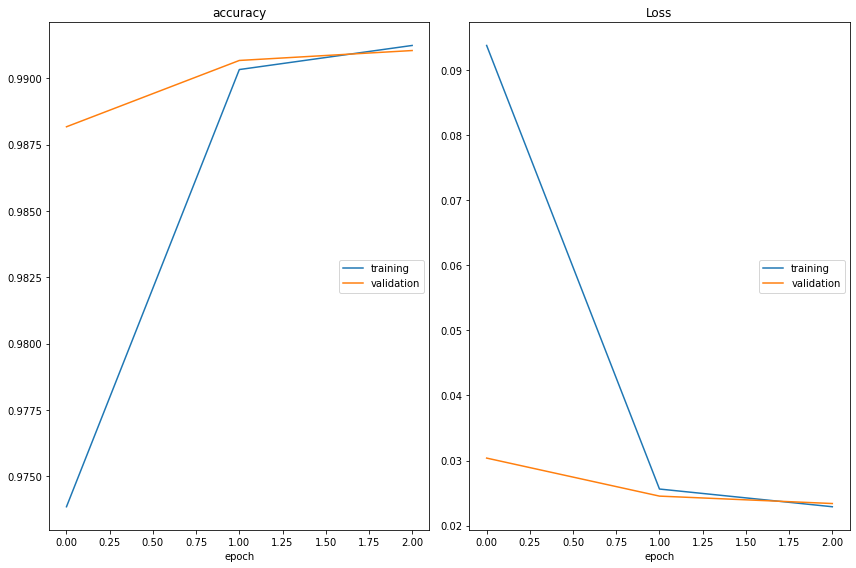

accuracy
	training         	 (min:    0.974, max:    0.991, cur:    0.991)
	validation       	 (min:    0.988, max:    0.991, cur:    0.991)
Loss
	training         	 (min:    0.023, max:    0.094, cur:    0.023)
	validation       	 (min:    0.023, max:    0.030, cur:    0.023)


In [30]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=1, 
                               verbose=0, mode='max', restore_best_weights=False)
callbacks = [PlotLossesCallback(), early_stopping ]
history = model.fit(
    X_train, np.array(y_train), 
    # validation_data=(X_test, np.array(y_test)),
    validation_split =0.3 ,
    batch_size = 16, 
    epochs= 3,
    verbose = 1,
    callbacks=callbacks
)

In [48]:
model.save(params['save_dir'])
# tf.saved_model.save(model, params['save_dir'])

INFO:tensorflow:Assets written to: drive/MyDrive/recipes/saved_model_tf/model4/assets


Evaluate

In [38]:
metrics = model.evaluate(X_test, np.array(y_test))
print(metrics)

39/39 [==============================] - 6s 152ms/step - loss: 0.0240 - accuracy: 0.9909
[0.023968150839209557, 0.9909257888793945]


In [37]:
i

268

In [36]:
i = np.random.randint(0, X_test.shape[0])
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)

y_true = np.argmax(np.array(y_test), axis=-1)[i]
print("{:15}{:9}\t {}\n".format("Recipe word", "True", "Pred"))
print("-"*50)

# print(X_test[i])
# print(y_true)
# print(p[0])
for w, true, pred in zip(X_test[i], y_true, p[0]):
    # print(words[w], labels_lookup[true], labels_lookup[pred])
    print("{:15}{:9}\t {}".format(word_lookup[w], labels_lookup[true], labels_lookup[pred]))

Recipe word    True     	 Pred

--------------------------------------------------
sprinkle       O        	 O
gelatin        S-INGREDIENT	 O
over           O        	 O
cold           O        	 O
water          S-INGREDIENT	 S-INGREDIENT
and            O        	 O
set            O        	 O
aside          O        	 O
to             O        	 O
soften         O        	 O
whisk          O        	 O
together       O        	 O
cup            O        	 O
plus           O        	 O
tablespoon     O        	 O
sugar          O        	 O
and            O        	 O
cornstarch     S-INGREDIENT	 S-INGREDIENT
in             O        	 O
a              O        	 O
small          O        	 O
bowl           O        	 O
whisk          O        	 O
in             O        	 O
the            O        	 O
eggs           O        	 O
and            O        	 O
add            O        	 O
the            O        	 O
milk           S-INGREDIENT	 S-INGREDIENT
cook           O        	 O
in  

Inference

In [49]:
reconstructed_model = load_model(params['save_dir'])
reconstructed_model.summary()

# reconstructed_model = tf.saved_model.load(params['save_dir'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 150, 150)          805200    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 150, 150)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 150, 300)          361200    
_________________________________________________________________
time_distributed (TimeDistri (None, 150, 5)            1505      
Total params: 1,167,905
Trainable params: 1,167,905
Non-trainable params: 0
_________________________________________________________________


In [51]:
i = np.random.randint(0, X_test.shape[0])
p = reconstructed_model(np.array([X_test[i]]))
# model.predict(np.array(X_test[i: i+2]))
p = np.argmax(p, axis=-1)

y_true = np.argmax(np.array(y_test), axis=-1)[i]
print("{:15}{:9}\t {}\n".format("Recipe word", "True", "Pred"))
print("-"*50)

# print(X_test[i])
# print(y_true)
# print(p[0])
for w, true, pred in zip(X_test[i], y_true, p[0]):
    # print(words[w], labels_lookup[true], labels_lookup[pred])
    print("{:15}{:9}\t {}".format(word_lookup[w], labels_lookup[true], labels_lookup[pred]))

Recipe word    True     	 Pred

--------------------------------------------------
melt           O        	 O
chocolate      S-INGREDIENT	 S-INGREDIENT
in             O        	 O
double         O        	 O
boiler         O        	 O
beat           O        	 O
shortening     S-INGREDIENT	 S-INGREDIENT
with           O        	 O
sugar          O        	 O
add            O        	 O
eggs           O        	 O
salt           S-INGREDIENT	 S-INGREDIENT
baking         B-INGREDIENT	 B-INGREDIENT
soda           E-INGREDIENT	 E-INGREDIENT
cinnamon       S-INGREDIENT	 S-INGREDIENT
cloves         O        	 O
and            O        	 O
melted         O        	 O
chocolate      S-INGREDIENT	 S-INGREDIENT
add            O        	 O
flour          S-INGREDIENT	 S-INGREDIENT
alternately    O        	 O
with           O        	 O
milk           S-INGREDIENT	 S-INGREDIENT
beating        O        	 O
first          O        	 O
with           O        	 O
electric       O        	 O
mixer  

In [52]:
res = model.predict(np.array(X_test[i: i+2]))
res.shape

(2, 150, 5)